# Making our own colour-colour to mass-to-light ratio calibration

Isaac Cheng - November 2021

Using as many galaxies in the NGVS-VERTICO sample as possible in this lookup table.

Run the cell below then start from step 3.


In [1]:
# Need to switch directories if using VS Code + sshfs
LOOKUP_PATH = "/arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/"
%cd "$LOOKUP_PATH"
# 
import astropy.coordinates as coord
import astropy.units as u
import dill
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from astropy.io import fits
from astropy.wcs import WCS
from scipy.stats import gaussian_kde
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
# import radial_profile_utils as rpu
# from radial_profile import RadialProfile
# Reload my packages
import importlib
importlib.reload(fu)
importlib.reload(pu)
# importlib.reload(rpu)
# 
GALDIST = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty

/arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table


# 1. Ensure each bin is only represented once (already done except for 2 galaxies)

i.e., each bin should be treated equally. Just because one Voronoi bin has 10x the pixels of the another, both are effectively "1 pixel" in our colour-colour space

Also, since some galaxies (i.e., NGC 4298 and NGC 4424) have overflow errors in the g-band (causing the SNR in the bin to be zero within floating point uncertainty), we will only consider bins that have SNRs >= 30.

NGC 4302 may have overflowed in i-band...


In [2]:
from numba import njit, prange
from itertools import repeat
from multiprocessing import Pool


# @njit(parallel=False)  # will clash with multiprocessing if parallel=True
# def select_one_from_each_bin(arr, bin_nums):
#     arr = arr.flatten()
#     bin_nums = bin_nums.flatten()
#     num_bins = int(np.nanmax(bin_nums) + 1)
#     tmp_arr = np.full(num_bins, np.nan)
#     for i in prange(num_bins):
#         tmp_arr[i] = arr[bin_nums == i][0]
#     return tmp_arr

@njit(parallel=False)  # will clash with multiprocessing if parallel=True
def select_one_from_each_bin(arr, bin_nums, unique_bin_nums):
    """
    Must ensure all incoming arrays are 1D (for numba)
    """
    tmp_arr_size = unique_bin_nums.size
    tmp_arr = np.full(tmp_arr_size, np.nan)
    for i, unique_bin_num in zip(prange(tmp_arr_size), unique_bin_nums):
        # print("i", i, "unique_bin_num", unique_bin_num, "bin_nums shape", bin_nums.shape, "arr shape", arr.shape)
        # tmptmparr = bin_nums == unique_bin_num
        # print("bin_nums == unique_bin_num shape", tmptmparr.shape)
        tmp_arr[i] = arr[bin_nums == unique_bin_num][0]
    return tmp_arr


def select_one_from_each_bin_multi(arr_of_arrs, bin_nums, processes=None):
    """
    arrs should be 1d array of arrays
    """
    unique_bin_nums = np.unique(bin_nums).astype(int)
    unique_bin_nums = np.sort(unique_bin_nums)
    print("Number of unique bins:", unique_bin_nums.size)
    print("Total(-ish) number of bins:", bin_nums.max() + 1)
    with Pool(processes=processes) as p:
        results = p.starmap(
            select_one_from_each_bin, zip(arr_of_arrs, repeat(bin_nums), repeat(unique_bin_nums))
        )
    return results, unique_bin_nums


tmp_arr2 = np.arange(11)
tmp_arr2 = select_one_from_each_bin(tmp_arr2, tmp_arr2.astype(int), tmp_arr2.astype(int))


In [3]:
GALAXY = "NGC4216"
GALPATH = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{GALAXY}/"
SNR_TARGET = 50  # specifies which Voronoi-binning file to use
print("-" * 5, GALAXY, "-" * 5)
#
# Load Voronoi-binned data
#
vorbin_results = GALPATH + f"{GALAXY}_vorbin_SNR{SNR_TARGET}_ugizBinned.pkl"
with open(vorbin_results, "rb") as f:
    file = dill.load(f)
    uband_signal_vorbin = file["uband_signal"]
    uband_noise_vorbin = file["uband_noise"]
    gband_signal_vorbin = file["gband_signal"]
    gband_noise_vorbin = file["gband_noise"]
    iband_signal_vorbin = file["iband_signal"]
    iband_noise_vorbin = file["iband_noise"]
    zband_signal_vorbin = file["zband_signal"]
    zband_noise_vorbin = file["zband_noise"]
    px_per_vorbin = file["px_per_bin"]
    binNum_vorbin = file["binNum"]  # just to check how many original bins
    binNum_arr_vorbin = file["binNum_arr"]
# vorbin_npixels_file = GALPATH + f"{GALAXY}_vorbin_SNR{SNR_TARGET}_In+Out.pkl"
# with open(vorbin_npixels_file, "rb") as f:
#     file = dill.load(f)
#     nPixels = file["nPixels"]
#
# Select only 1 point from each bin (since bins have different sizes and are thus weighted
# differently if we don't do this)
# Also, only choose bins with SNR >= 30 and ensure all the array shapes match
#
uband_snr_vorbin = uband_signal_vorbin / uband_noise_vorbin
isgood_uband_snr = (uband_snr_vorbin >= 30) & np.isfinite(uband_snr_vorbin)
gband_snr_vorbin = gband_signal_vorbin / gband_noise_vorbin
isgood_gband_snr = (gband_snr_vorbin >= 30) & np.isfinite(gband_snr_vorbin)
iband_snr_vorbin = iband_signal_vorbin / iband_noise_vorbin
isgood_iband_snr = (iband_snr_vorbin >= 30) & np.isfinite(iband_snr_vorbin)
zband_snr_vorbin = zband_signal_vorbin / zband_noise_vorbin
isgood_zband_snr = (zband_snr_vorbin >= 30) & np.isfinite(zband_snr_vorbin)
# 
isgood_snr = (isgood_gband_snr) & (isgood_zband_snr) & (isgood_uband_snr) & (isgood_iband_snr)
# 
arr_of_bands = [
    uband_signal_vorbin[isgood_snr],
    uband_noise_vorbin[isgood_snr],
    gband_signal_vorbin[isgood_snr],
    gband_noise_vorbin[isgood_snr],
    iband_signal_vorbin[isgood_snr],
    iband_noise_vorbin[isgood_snr],
    zband_signal_vorbin[isgood_snr],
    zband_noise_vorbin[isgood_snr],
    px_per_vorbin[isgood_snr]
]
starttime = time.time()
arr_of_results, unique_binNum = select_one_from_each_bin_multi(
    arr_of_bands, binNum_arr_vorbin[isgood_snr].astype(int), processes=9
)
endtime = time.time()
print(f"It took {(endtime - starttime) / 60:.2f} minutes to finish this step")
# Save results
lookup_inputs_outfile = LOOKUP_PATH + f"{GALAXY}_lookupInputs.pkl"
with open(lookup_inputs_outfile, "wb") as f:
    dill.dump(
        {
            "uband_signal": arr_of_results[0],
            "uband_noise": arr_of_results[1],
            "gband_signal": arr_of_results[2],
            "gband_noise": arr_of_results[3],
            "iband_signal": arr_of_results[4],
            "iband_noise": arr_of_results[5],
            "zband_signal": arr_of_results[6],
            "zband_noise": arr_of_results[7],
            "bin_num": unique_binNum,
            "px_per_bin": arr_of_results[8],
        },
        f,
    )
print("Pickled", lookup_inputs_outfile)
print()
print("Number of good Voronoi bins:", arr_of_results[0].shape)

----- NGC4216 -----


Number of unique bins: 221250
Total(-ish) number of bins: 221412
It took 21.38 minutes to finish this step
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/NGC4216_lookupInputs.pkl

Number of good Voronoi bins: (221250,)


In [4]:
print("-" * 5, "Results for", GALAXY, "-" * 5)
print("Number of good pixels", np.sum(isgood_snr), "\tTotal number of pixels:", uband_signal_vorbin.size)
print("Original number of bins:", binNum_vorbin.max() + 1)
print("Number of unique bins:", unique_binNum.size, "\tMaximum bin number:", unique_binNum.max())
print("Relative percentage of good bins:", unique_binNum.size / (binNum_vorbin.max() + 1) * 100)

----- Results for NGC4216 -----
Number of good pixels 3327307 	Total number of pixels: 3508128
Original number of bins: 221414
Number of unique bins: 221250 	Maximum bin number: 221411
Relative percentage of good bins: 99.92593060962722


In [5]:
print(np.min(arr_of_results[8]))
print(arr_of_results[8].dtype)
print(unique_binNum.dtype)

1.0
float64
int64


# 2. Compile all the galaxies' data into one array (already done)

Note that I manually removed any g-z colours <= 0 for NGC 4216 since those colours
correspond to the area around the unflagged foreground star.

For future analysis, it would be best if Voronoi binning was re-run on NGC 4216 except
with the foreground star already masked out (before beginning Voronoi binning).


In [2]:
GALAXIES = [
    "IC3392",
    # "NGC4189",  # ignored flag map, but bad results
    "NGC4192",
    "NGC4216",  # has unflagged foreground star
    "NGC4222",
    "NGC4254",
    "NGC4294",
    "NGC4298",
    "NGC4299",
    "NGC4302",
    "NGC4321",
    "NGC4330",
    "NGC4351",
    "NGC4380",
    "NGC4383",
    "NGC4388",
    "NGC4396",
    "NGC4402",
    "NGC4405",
    "NGC4419",
    "NGC4424",
    "NGC4450",
    "NGC4501",
    "NGC4522",
    "NGC4532",
    "NGC4535",
    "NGC4548",
    "NGC4567",
    "NGC4568",
    "NGC4569",
    "NGC4579",
    "NGC4580",
    # "NGC4606",  # flag map too intrusive
    "NGC4607",
    "NGC4651",
    "NGC4654",
    "NGC4689",
    "NGC4694",
]
uband_signal = np.array([], dtype=float)
uband_noise = np.array([], dtype=float)
gband_signal = np.array([], dtype=float)
gband_noise = np.array([], dtype=float)
iband_signal = np.array([], dtype=float)
iband_noise = np.array([], dtype=float)
zband_signal = np.array([], dtype=float)
zband_noise = np.array([], dtype=float)
bin_num = np.array([], dtype=int)
px_per_bin = np.array([], dtype=float)
for gal in GALAXIES:
    with open(LOOKUP_PATH + f"{gal}_lookupInputs.pkl", "rb") as f:
        file = dill.load(f)
        # Load everything here
        tmp_usig = file["uband_signal"]
        tmp_unoise = file["uband_noise"]
        tmp_gsig = file["gband_signal"]
        tmp_gnoise = file["gband_noise"]
        tmp_isig = file["iband_signal"]
        tmp_inoise = file["iband_noise"]
        tmp_zsig = file["zband_signal"]
        tmp_znoise = file["zband_noise"]
        tmp_bin_num = file["bin_num"]
        tmp_px_per_bin = file["px_per_bin"]
        if gal == "NGC4216":
            # Manually remove g-z colours <= 0 for NGC 4216
            # (i.e., colours corresponding to area around foreground star)
            is_good = fu.calc_colour(tmp_gsig, tmp_zsig) > 0
            tmp_usig = tmp_usig[is_good]
            tmp_unoise = tmp_unoise[is_good]
            tmp_gsig = tmp_gsig[is_good]
            tmp_gnoise = tmp_gnoise[is_good]
            tmp_isig = tmp_isig[is_good]
            tmp_inoise = tmp_inoise[is_good]
            tmp_zsig = tmp_zsig[is_good]
            tmp_znoise = tmp_znoise[is_good]
            tmp_bin_num = tmp_bin_num[is_good]
            tmp_px_per_bin = tmp_px_per_bin[is_good]
        # Add to existing arrays
        uband_signal = np.append(uband_signal, tmp_usig)
        uband_noise = np.append(uband_noise, tmp_unoise)
        gband_signal = np.append(gband_signal, tmp_gsig)
        gband_noise = np.append(gband_noise, tmp_gnoise)
        iband_signal = np.append(iband_signal, tmp_isig)
        iband_noise = np.append(iband_noise, tmp_inoise)
        zband_signal = np.append(zband_signal, tmp_zsig)
        zband_noise = np.append(zband_noise, tmp_znoise)
        bin_num = np.append(bin_num, tmp_bin_num)
        px_per_bin = np.append(px_per_bin, tmp_px_per_bin)
px_per_bin = px_per_bin.astype(int)
# 
# Save compiled arrays
# 
total_lookup_inputs_outfile = LOOKUP_PATH + f"TOTAL_no4189_lookupInputs.pkl"
with open(total_lookup_inputs_outfile, "wb") as f:
    dill.dump(
        {
            "uband_signal": uband_signal,
            "uband_noise": uband_noise,
            "gband_signal": gband_signal,
            "gband_noise": gband_noise,
            "iband_signal": iband_signal,
            "iband_noise": iband_noise,
            "zband_signal": zband_signal,
            "zband_noise": zband_noise,
            "bin_num": bin_num,
            "px_per_bin": px_per_bin,
        },
        f
    )
print("Pickled", total_lookup_inputs_outfile)

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/TOTAL_no4189_lookupInputs.pkl


# 3. Calculate colours and magnitudes

Note that I have _not_ corrected for Galactic extinction in these data.


In [2]:
# 
# Load data
# 
total_lookup_inputs_infile = LOOKUP_PATH + f"TOTAL_no4189_lookupInputs.pkl"
with open(total_lookup_inputs_infile, "rb") as f:
    file = dill.load(f)
    uband_signal = file["uband_signal"]
    uband_noise = file["uband_noise"]
    gband_signal = file["gband_signal"]
    gband_noise = file["gband_noise"]
    iband_signal = file["iband_signal"]
    iband_noise = file["iband_noise"]
    zband_signal = file["zband_signal"]
    zband_noise = file["zband_noise"]
    bin_num = file["bin_num"]
    px_per_bin = file["px_per_bin"]
    file = None  # free memory
# 
# Normalize fluxes by number of pixels
# 
uband_signal = uband_signal / px_per_bin
uband_noise = uband_noise / px_per_bin
gband_signal = gband_signal / px_per_bin
gband_noise = gband_noise / px_per_bin
iband_signal = iband_signal / px_per_bin
iband_noise = iband_noise / px_per_bin
zband_signal = zband_signal / px_per_bin
zband_noise = zband_noise / px_per_bin
# 
# Calculate colours
#
gz_colour_vorbin = fu.calc_colour(gband_signal, zband_signal)
ui_colour_vorbin = fu.calc_colour(uband_signal, iband_signal)
# 
# Calculate absolute magniutudes
# 
uband_mag, uband_mag_err = fu.calc_mag(uband_signal, uband_noise, calc_abs=True, dist=GALDIST.to(u.pc).value)
gband_mag, gband_mag_err = fu.calc_mag(gband_signal, gband_noise, calc_abs=True, dist=GALDIST.to(u.pc).value)
iband_mag, iband_mag_err = fu.calc_mag(iband_signal, iband_noise, calc_abs=True, dist=GALDIST.to(u.pc).value)
zband_mag, zband_mag_err = fu.calc_mag(zband_signal, zband_noise, calc_abs=True, dist=GALDIST.to(u.pc).value)

In [3]:
print("g-z colour min/max:", np.min(gz_colour_vorbin), np.max(gz_colour_vorbin))
print("u-i colour min/max:", np.min(ui_colour_vorbin), np.max(ui_colour_vorbin))

g-z colour min/max: -1.1802304771319492 3.7832439171962458
u-i colour min/max: -0.774106106744094 5.8116938940376635


# 4. Make hexbin plot


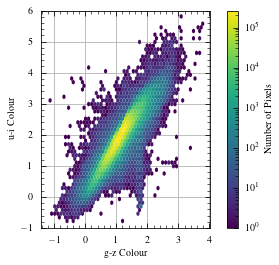

In [8]:
fig, ax = plt.subplots()
hb = ax.hexbin(
    gz_colour_vorbin.flatten(),
    ui_colour_vorbin.flatten(),
    gridsize=50,
    bins="log",  # will change the get_array() values
    mincnt=1,
    cmap="viridis",
    linewidths=0,
    # extent=[
    #     np.nanmin(gz_colour_vorbin),
    #     np.nanmax(gz_colour_vorbin),
    #     np.nanmin(ui_colour_vorbin),
    #     np.nanmax(ui_colour_vorbin),
    # ],
    zorder=2,
)
cbar = fig.colorbar(hb)
cbar.set_label("Number of Pixels")
ax.set_xlabel("g-z Colour")
ax.set_ylabel("u-i Colour")
ax.set_aspect("equal")
ax.set_xticks(np.arange(-1, 5).astype(int))
ax.set_ylim(-1, 6)
# ax.plot([-1, 4], [-1, 4], "k")  # y=x line
# fig.savefig(LOOKUP_PATH + f"TOTAL_no4189_ui_vs_gz_hexbin_v2.pdf")
plt.show()

## 4.1 Make hexbin plot of each galaxy overlaid on contour plot of all galaxies


In [3]:
import re
#
# Load data for 1 galaxy
# 
GALAXIES = [
    "IC3392",
    # "NGC4189",  # ignored flag map, but bad results
    "NGC4192",
    "NGC4216",  # has unflagged foreground star
    "NGC4222",
    "NGC4254",
    "NGC4294",
    "NGC4298",
    "NGC4299",
    "NGC4302",
    "NGC4321",
    "NGC4330",
    "NGC4351",
    "NGC4380",
    "NGC4383",
    "NGC4388",
    "NGC4396",
    "NGC4402",
    "NGC4405",
    "NGC4419",
    "NGC4424",
    "NGC4450",
    "NGC4501",
    "NGC4522",
    "NGC4532",
    "NGC4535",
    "NGC4548",
    "NGC4567",
    "NGC4568",
    "NGC4569",
    "NGC4579",
    "NGC4580",
    # "NGC4606",  # flag map too intrusive
    "NGC4607",
    "NGC4651",
    "NGC4654",
    "NGC4689",
    "NGC4694",
]
INCLINATIONS = [
    68,
    # 42,  # ignored flag map, but bad results
    83,
    90,  # has unflagged foreground star
    90,
    39,
    74,
    52,
    14,
    90,
    32,
    90,
    48,
    61,
    56,
    83,
    83,
    80,
    46,
    74,
    61,
    51,
    65,
    82,
    64,
    48,
    37,
    49,
    70,
    69,
    40,
    46,
    # 69,  # flag map too intrusive
    90,
    53,
    61,
    38,
    62,
]
for galaxy, i in zip(GALAXIES, INCLINATIONS):
    galaxy_inputs_infile = LOOKUP_PATH + f"{galaxy}_lookupInputs.pkl"
    with open(galaxy_inputs_infile, "rb") as f:
        file = dill.load(f)
        gal_uband_signal = file["uband_signal"]
        gal_uband_noise = file["uband_noise"]
        gal_gband_signal = file["gband_signal"]
        gal_gband_noise = file["gband_noise"]
        gal_iband_signal = file["iband_signal"]
        gal_iband_noise = file["iband_noise"]
        gal_zband_signal = file["zband_signal"]
        gal_zband_noise = file["zband_noise"]
        gal_px_per_bin = file["px_per_bin"]
        file = None  # free memory
    if galaxy == "NGC4216":
        # Manually remove g-z colours <= 0 for NGC 4216
        # (i.e., colours corresponding to area around foreground star)
        is_good = fu.calc_colour(gal_gband_signal, gal_zband_signal) > 0
        gal_uband_signal = gal_uband_signal[is_good]
        gal_uband_noise = gal_uband_noise[is_good]
        gal_gband_signal = gal_gband_signal[is_good]
        gal_gband_noise = gal_gband_noise[is_good]
        gal_iband_signal = gal_iband_signal[is_good]
        gal_iband_noise = gal_iband_noise[is_good]
        gal_zband_signal = gal_zband_signal[is_good]
        gal_zband_noise = gal_zband_noise[is_good]
        gal_px_per_bin = gal_px_per_bin[is_good]
    # 
    # Normalize fluxes by number of pixels
    # 
    uband_signal = gal_uband_signal / gal_px_per_bin
    uband_noise = gal_uband_noise / gal_px_per_bin
    gband_signal = gal_gband_signal / gal_px_per_bin
    gband_noise = gal_gband_noise / gal_px_per_bin
    iband_signal = gal_iband_signal / gal_px_per_bin
    iband_noise = gal_iband_noise / gal_px_per_bin
    zband_signal = gal_zband_signal / gal_px_per_bin
    zband_noise = gal_zband_noise / gal_px_per_bin
    # 
    # Calculate colours
    #
    gal_gz_colour_vorbin = fu.calc_colour(gal_gband_signal, gal_zband_signal)
    gal_ui_colour_vorbin = fu.calc_colour(gal_uband_signal, gal_iband_signal)
    # 
    # Plot
    # 
    fig, ax = plt.subplots()
    # sns.kdeplot(
    #     x=gz_colour_vorbin.flatten(),
    #     y=ui_colour_vorbin.flatten(),
    #     ax=ax,
    #     color="k",
    #     fill=False,
    # )
    hb = ax.hexbin(
        gz_colour_vorbin.flatten(),
        ui_colour_vorbin.flatten(),
        gridsize=50,
        bins="log",  # will change the get_array() values
        mincnt=1,
        cmap="Blues",
        linewidths=0,
        alpha=0.5,
        # extent=[
        #     np.nanmin(gz_colour_vorbin),
        #     np.nanmax(gz_colour_vorbin),
        #     np.nanmin(ui_colour_vorbin),
        #     np.nanmax(ui_colour_vorbin),
        # ],
        zorder=2,
    )
    hb2 = ax.hexbin(
        gal_gz_colour_vorbin.flatten(),
        gal_ui_colour_vorbin.flatten(),
        gridsize=50,
        bins="log",  # will change the get_array() values
        mincnt=1,
        cmap="viridis",
        linewidths=0,
        # extent=[
        #     np.nanmin(gz_colour_vorbin),
        #     np.nanmax(gz_colour_vorbin),
        #     np.nanmin(ui_colour_vorbin),
        #     np.nanmax(ui_colour_vorbin),
        # ],
        alpha=0.5,
        zorder=4,
    )
    cbar2 = fig.colorbar(hb2)
    cbar2.solids.set(alpha=1)  # opaque colour bar
    cbar2.set_label("Number of Pixels")
    ax.set_xlabel("g-z Colour")
    ax.set_ylabel("u-i Colour")
    ax.set_aspect("equal")
    ax.set_xticks(np.arange(-1, 5).astype(int))
    ax.set_ylim(-1, 6)
    #
    # Add name of galaxy
    #
    high_i_str = "*" if i >= 80 else ""
    ax.text(
        0.9,
        0.9,
        re.sub(r"(\d+)", " \\1", galaxy) + high_i_str,
        c="k",
        ha="right",
        transform=ax.transAxes,
    )
    fig.savefig(LOOKUP_PATH + f"{galaxy}_ui_vs_gz_overlay.pdf")
    plt.close()
print("Done!")

Done!


# 5. Make lookup table values and determine lookup bin of each pixel

Make lookup table spanning a g-z range of $[-1.0, 3.8]$ and u-i range of $[-0.8, 5.5]$
with bin sizes of 0.1 and 0.1 along each axis, respectively (these values chosen based on hexbin plot).

Additionally, we assign points beyond these colour limits to their closest bin.


In [4]:
GZ_STEP = 0.1
UI_STEP = 0.1
gz_vals = np.arange(-1.0, 3.8 + GZ_STEP, GZ_STEP)
ui_vals = np.arange(-0.8, 5.5 + UI_STEP, UI_STEP)
LOOKUP_GZ_LEN = gz_vals.size
LOOKUP_UI_LEN = ui_vals.size
print(gz_vals.min(), gz_vals.max(), LOOKUP_GZ_LEN)
print(ui_vals.min(), ui_vals.max(), LOOKUP_UI_LEN)
gz_spacing = np.diff(gz_vals)[0]
ui_spacing = np.diff(ui_vals)[0]
print("gz_spacing:", gz_spacing)
print("ui_spacing:", ui_spacing)
print()
#
# Assign each pixel to its bin. If values beyond the edges of the lookup table, assign to
# closest bin
#
# Since the *_vals arrays are increasing & right=False, the returned index satisfies:
# bins[i] <= x < bins[i+1] (since I subtracted 1 from the bin number)
gz_idx = np.digitize(gz_colour_vorbin, gz_vals, right=False) - 1
ui_idx = np.digitize(ui_colour_vorbin, ui_vals, right=False) - 1
# # Assign points beyond g-z and u-i ranges to closest bin (method 1)
# gz_idx[gz_idx == LOOKUP_GZ_LEN] = LOOKUP_GZ_LEN - 1
# ui_idx[ui_idx == LOOKUP_UI_LEN] = LOOKUP_UI_LEN - 1
# gz_idx[gz_idx < 0] = 0
# ui_idx[ui_idx < 0] = 0
# Negative index indicates bad value
gz_idx_mask = np.isnan(gz_colour_vorbin)
ui_idx_mask = np.isnan(ui_colour_vorbin)
gz_idx[gz_idx_mask] = -1
ui_idx[ui_idx_mask] = -1
# Assign points beyond g-z and u-i ranges to closest bin (method 2)
gz_idx[gz_colour_vorbin <= gz_vals.min()] = 0
ui_idx[ui_colour_vorbin <= ui_vals.min()] = 0
gz_idx[gz_colour_vorbin >= gz_vals.max()] = LOOKUP_GZ_LEN - 1
ui_idx[ui_colour_vorbin >= ui_vals.max()] = LOOKUP_UI_LEN - 1
# # Print some values for sanity check
# print(gz_idx.shape)
# print(gz_idx[0])
# print(gz_colour_vorbin[0])
# print(gz_vals[25])
# print(np.min(gz_idx))
# print(np.min(gz_idx[gz_idx > -1]))
# print(np.max(gz_idx))
# print(np.max(gz_idx[gz_idx < np.max(gz_idx)]))
# print()
# print(ui_idx.shape)
# print(ui_idx[0])
# print(ui_colour_vorbin[0])
# print(ui_vals[35])
# print(np.min(ui_idx))
# print(np.min(ui_idx[ui_idx > -1]))
# print(np.max(ui_idx))
# print(np.max(ui_idx[ui_idx < np.max(ui_idx)]))
# print(np.sum(gz_idx < 0), np.sum(ui_idx < 0))
# print(np.sum(gz_idx_mask), np.sum(ui_idx_mask))

-1.0 3.799999999999999 49
-0.8 5.499999999999999 64
gz_spacing: 0.09999999999999998
ui_spacing: 0.09999999999999998



In [5]:
#
# Make pandas dataframe containing the bins in the rows and band fluxes in the columns.
# The row headers will have a format <g-z bin>_<u-i bin>
#
rows = []
for gz_bin in range(LOOKUP_GZ_LEN):
    for ui_bin in range(LOOKUP_UI_LEN):
        rows.append(f"{gz_bin}_{ui_bin}")
lookup_df = pd.DataFrame(
    columns=["u", "u_err", "g", "g_err", "i", "i_err", "z", "z_err"], index=rows
).astype("object")
print(lookup_df)
# print(lookup_df.dtypes)


         u u_err    g g_err    i i_err    z z_err
0_0    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_1    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_2    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_3    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_4    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
...    ...   ...  ...   ...  ...   ...  ...   ...
48_59  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
48_60  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
48_61  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
48_62  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
48_63  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN

[3136 rows x 8 columns]


In [6]:
#
# Populate pandas dataframe
#
nan_arr = np.array([np.nan])


def _assign_to_df(_band, _mask):
    _tmp_arr = _band[_mask]
    if _tmp_arr.size == 0:
        _tmp_arr = nan_arr
    return _tmp_arr

for gz_bin in range(LOOKUP_GZ_LEN):
    for ui_bin in range(LOOKUP_UI_LEN):
        tmp_row = f"{gz_bin}_{ui_bin}"
        tmp_mask = (gz_idx == gz_bin) & (ui_idx == ui_bin)
        # lookup_df.at[tmp_row, "u"] = _assign_to_df(uband_signal_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "u_err"] = _assign_to_df(uband_noise_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "g"] = _assign_to_df(gband_signal_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "g_err"] = _assign_to_df(gband_noise_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "i"] = _assign_to_df(iband_signal_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "i_err"] = _assign_to_df(iband_noise_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "z"] = _assign_to_df(zband_signal_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "z_err"] = _assign_to_df(zband_noise_vorbin, tmp_mask)
        lookup_df.at[tmp_row, "u"] = _assign_to_df(uband_mag, tmp_mask)
        lookup_df.at[tmp_row, "u_err"] = _assign_to_df(uband_mag_err, tmp_mask)
        lookup_df.at[tmp_row, "g"] = _assign_to_df(gband_mag, tmp_mask)
        lookup_df.at[tmp_row, "g_err"] = _assign_to_df(gband_mag_err, tmp_mask)
        lookup_df.at[tmp_row, "i"] = _assign_to_df(iband_mag, tmp_mask)
        lookup_df.at[tmp_row, "i_err"] = _assign_to_df(iband_mag_err, tmp_mask)
        lookup_df.at[tmp_row, "z"] = _assign_to_df(zband_mag, tmp_mask)
        lookup_df.at[tmp_row, "z_err"] = _assign_to_df(zband_mag_err, tmp_mask)


In [7]:
lookup_df

,u,u_err,g,g_err,i,i_err,z,z_err
0_0,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
0_1,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
0_2,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
0_3,"[-8.709859084258024, -8.933453359451896, -8.83...","[0.003605315780787221, 0.0032434869166323263, ...","[-9.230957744543911, -9.431806169534568, -9.42...","[0.0020322833064388294, 0.0018476019052432824,...","[-8.24615144871845, -8.46022060441566, -8.3399...","[0.005654780479413437, 0.005014896271235801, 0...","[-8.289673061829586, -8.445437768496287, -8.38...","[0.007199478747176044, 0.006528781498412281, 0..."
0_4,[-8.71051826423406],[0.003604189063395036],[-9.350764747685165],[0.0019198949707718844],[-8.378197408996439],[0.005248993029757293],[-8.338339626610562],[0.006981053247681696]
...,...,...,...,...,...,...,...,...
48_59,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
48_60,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
48_61,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
48_62,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]


In [8]:
def get_longest_row(df, col):
    return max(df[col], key=len)

print(len(get_longest_row(lookup_df, "u")))
print(len(get_longest_row(lookup_df, "u_err")))
print(len(get_longest_row(lookup_df, "g")))
print(len(get_longest_row(lookup_df, "g_err")))
print(len(get_longest_row(lookup_df, "i")))
print(len(get_longest_row(lookup_df, "i_err")))
print(len(get_longest_row(lookup_df, "z")))
print(len(get_longest_row(lookup_df, "z_err")))
print(get_longest_row(lookup_df, "u"))
print(get_longest_row(lookup_df, "u_err"))
print(get_longest_row(lookup_df, "g"))
print(get_longest_row(lookup_df, "g_err"))
print(get_longest_row(lookup_df, "i"))
print(get_longest_row(lookup_df, "i_err"))
print(get_longest_row(lookup_df, "z"))
print(get_longest_row(lookup_df, "z_err"))


229519
229519
229519
229519
229519
229519
229519
229519
[-5.91402431 -4.69179497 -4.71258433 ... -4.13373726 -4.38453277
 -3.9720387 ]
[0.01347762 0.0210494  0.02074082 ... 0.02091824 0.02000364 0.02369796]
[-7.11080385 -5.98809032 -6.01029641 ... -5.39019739 -5.58547855
 -5.21261114]
[0.00507844 0.00685686 0.00676268 ... 0.00768336 0.00776493 0.00870386]
[-8.16249005 -6.98278424 -6.96069241 ... -6.42296293 -6.604867
 -6.2114797 ]
[0.00554348 0.00819979 0.00832499 ... 0.00958004 0.00965172 0.01127127]
[-8.41065296 -7.19209678 -7.23370912 ... -6.59486952 -6.78723625
 -6.43357629]
[0.00629046 0.01042609 0.01010172 ... 0.01228633 0.01216594 0.01400783]


# 6. Save results for SED fitting

Note that I have _not_ corrected for Galactic extinction in these data.


In [9]:
# 
# Check that the number of pixels in each column in the same row are all the same. Passed
# 
# for gz_bin in range(LOOKUP_GZ_LEN):
#     for ui_bin in range(LOOKUP_UI_LEN):
#         tmp_row = f"{gz_bin}_{ui_bin}"
#         tmp_series = lookup_df.loc[tmp_row].values
#         tmp_mysize = tmp_series[0].size
#         for i in range(tmp_series.size):
#             if tmp_series[i].size != tmp_mysize:
#                 print("Failed on", tmp_row)
# 
# Select max of 10 random pixels per 2D bin
# 
MAX_PX_PER_BIN = 10
selected_pixels = []
# 
# First row of the text file
# 
# selected_pixels.append(["id", "z", "counts_u", "err_u", "counts_g", "err_g", "counts_i", "err_i", "counts_z", "err_z"])
selected_pixels.append(["id", "z", "u_mag", "u_mag_err", "g_mag", "g_mag_err", "i_mag", "i_mag_err", "z_mag", "z_mag_err"])
# 
rng = np.random.default_rng(761)
len_digits = max([len(str(LOOKUP_GZ_LEN)), len(str(LOOKUP_UI_LEN))])
for gz_bin in range(LOOKUP_GZ_LEN):
    for ui_bin in range(LOOKUP_UI_LEN):
        tmp_row = f"{gz_bin}_{ui_bin}"
        tmp_series = lookup_df.loc[tmp_row]
        tmp_num_px = tmp_series.values[0].size  # number of pixels in the bin
        if tmp_num_px > MAX_PX_PER_BIN:
            tmp_row_idx = rng.choice(tmp_num_px, size=MAX_PX_PER_BIN, replace=False).astype(int)
            tmp_row_idx = np.sort(tmp_row_idx)
        else:
            tmp_row_idx = range(tmp_num_px)
        # 
        tmp_id = str(gz_bin).zfill(len_digits) + str(ui_bin).zfill(len_digits)
        if tmp_num_px == 1:
            if np.isnan(float(tmp_series["u"])):  # don't bother adding NaNs
                continue
            selected_pixels.append(
                [
                    tmp_id + "0",
                    0.0,
                    float(tmp_series["u"]),
                    float(tmp_series["u_err"]),
                    float(tmp_series["g"]),
                    float(tmp_series["g_err"]),
                    float(tmp_series["i"]),
                    float(tmp_series["i_err"]),
                    float(tmp_series["z"]),
                    float(tmp_series["z_err"]),
                ]
            )
        else:
            for i, element in enumerate(tmp_row_idx):
                selected_pixels.append(
                    [
                        tmp_id + str(i),
                        0.0,
                        float(tmp_series["u"][element]),
                        float(tmp_series["u_err"][element]),
                        float(tmp_series["g"][element]),
                        float(tmp_series["g_err"][element]),
                        float(tmp_series["i"][element]),
                        float(tmp_series["i_err"][element]),
                        float(tmp_series["z"][element]),
                        float(tmp_series["z_err"][element]),
                    ]
                )


In [10]:
# 
# Save the selected pixels to text file for SED fitting
# 
import csv

# selected_pixels_filename = GALPATH + f"{GALAXY}_lookupFluxes.txt"
selected_pixels_filename = LOOKUP_PATH + f"TOTAL_no4189_lookupMagnitudes.txt"
with open(selected_pixels_filename, "w") as f:
    wr = csv.writer(f, delimiter=" ")
    wr.writerows(selected_pixels)
print("Saved", selected_pixels_filename)

Saved /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/TOTAL_no4189_lookupMagnitudes.txt


# 7. Read SED fitting results and compile into 1 array
